/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: Convergenc

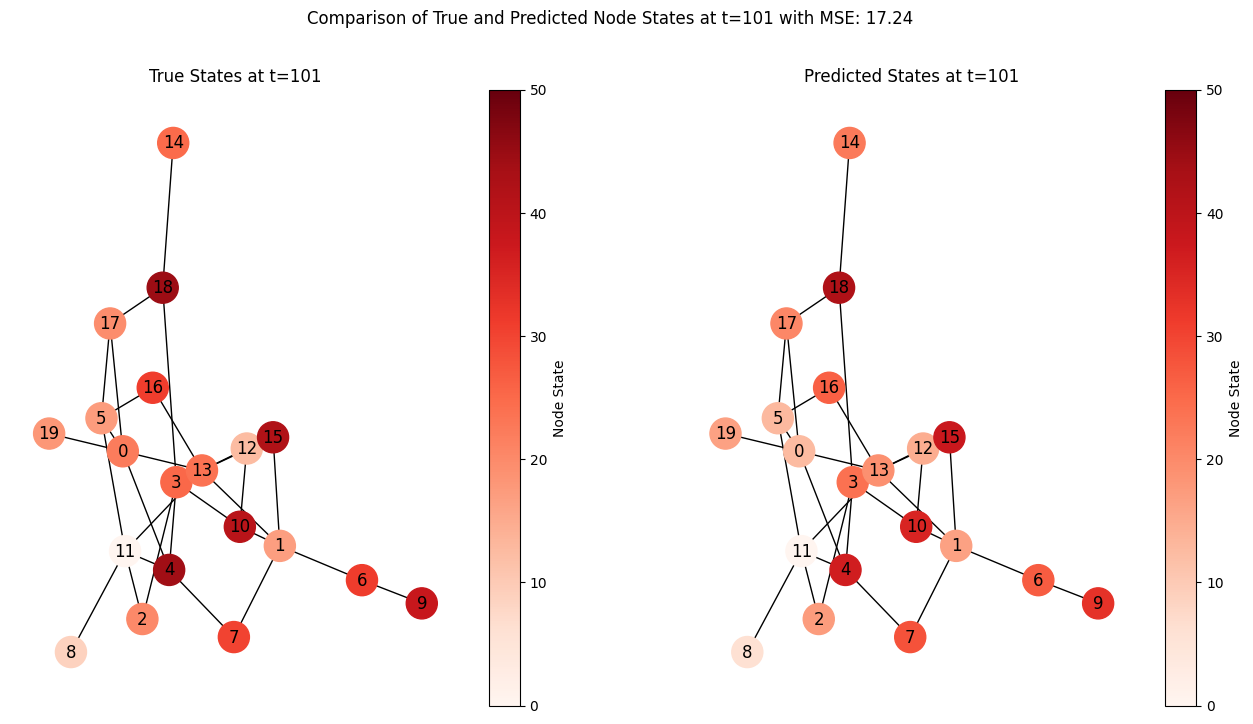

In [61]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error

# Set the seed for reproducibility
np.random.seed(12)

# Create a random graph with 20 nodes
G = nx.erdos_renyi_graph(n=20, p=0.15, seed=12)

# Assign random coefficients for sine and cosine functions with a broader range
node_params = {node: (np.random.uniform(-12, 12, size=5), np.random.uniform(-12, 12, size=5)) for node in G.nodes}

# Function to compute observable state based on trigonometric functions with random coefficients
def compute_state(node, time_point):
    sine_coeffs, cos_coeffs = node_params[node]
    time = np.linspace(0, 10, 101)
    sine_wave = np.dot(sine_coeffs, np.sin(time[time_point] * np.linspace(1, 5, 5)))
    cos_wave = np.dot(cos_coeffs, np.cos(time[time_point] * np.linspace(1, 5, 5)))
    return np.clip(sine_wave + cos_wave + 25, 0, 50)  # Center around 25 and limit between 0 and 50

# Simulate states over 100 time points
states = {node: [] for node in G.nodes}
for time_point in range(101):
    for node in G.nodes:
        current_state = compute_state(node, time_point)
        states[node].append(current_state)

# Training and prediction setup
X_train = np.arange(0, 100).reshape(-1, 1)  # Time points as training features
y_train = np.array([states[node][:100] for node in states]).T  # Training data up to t=100
X_test = np.array([[100]])  # Predict at t=101

# Gaussian Process for each node
predicted_states = {}
kernel = C(1.0, (1e-2, 1e2)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
for node in G.nodes:
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
    gp.fit(X_train, y_train[:, node])
    predicted_states[node], _ = gp.predict(X_test, return_std=True)

# True states at t=101 for comparison
true_states = np.array([states[node][100] for node in states])

# Calculate mean squared error
mse = mean_squared_error(true_states, [predicted_states[node][0] for node in G.nodes])

# Visualization of the network with node states
pos = nx.spring_layout(G, seed=12)  # Node positions
cmap = plt.cm.Reds  # Color map
norm = mcolors.Normalize(vmin=0, vmax=50)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# True states subplot
nx.draw(G, pos, node_color=[cmap(norm(state)) for state in true_states], with_labels=True, node_size=500, cmap=cmap, ax=axes[0])
axes[0].set_title('True States at t=101')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes[0], label='Node State')

# Predicted states subplot
nx.draw(G, pos, node_color=[cmap(norm(predicted_states[node][0])) for node in G.nodes], with_labels=True, node_size=500, cmap=cmap, ax=axes[1])
axes[1].set_title('Predicted States at t=101')
plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes[1], label='Node State')

plt.suptitle(f'Comparison of True and Predicted Node States at t=101 with MSE: {mse:.2f}')
plt.show()
